In [ ]:
import mne
import pathlib
from mne.externals.pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d

In [ ]:
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

# Importing & Parsing the csv

In [120]:
def csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,filename,montage = 'GSN-HydroCel-129'):
    ''' Load csv files of data, chan locations and events and return a raw mne instance'''
    data = np.loadtxt(path_to_file,delimiter =',')
    chans = pd.read_csv(path_to_montage_ses,sep = ',',header = None)
    ch_list=['E1', 'E8', 'E14', 'E17', 'E21', 'E25', 'E32', 'E38', 'E43', 'E44', 'E48', 'E49', 'E56', 'E57', 'E63', 'E64', 'E69', 'E73', 'E74', 'E81', 'E82', 'E88', 'E89', 'E94', 'E95', 'E99', 'E100', 'E107', 'E113', 'E114', 'E119', 'E120', 'E121', 'E125', 'E126', 'E127', 'E128']
    ch_names = list(chans.values[1:,0])
#print(type(ch_names))
    #ch_names_appended = list(np.append(ch_names,'stim_channel'))
    #print(len(data[0]))
    types = ['eeg']*(len(ch_names))
    #types.append('stim')
    #data2 = np.zeros([1,len(data[0])]) #len(raw.times)
    #data_appended = np.append(data,data2,axis = 0)

    #print(np.shape(data_appended))
#print(len(types))

#types
    info = mne.create_info(ch_names,sfreq = fs,ch_types = types)
#raw=mne.io.RawArray(data, info)

#mne.find_events(raw,stim_channel='stim')
    raw = mne.io.RawArray(data, info)
    
    # set standard montage
    if montage:
        raw.set_montage(montage)

    # events array shape must be (n_events,3)The first column specifies the sample number of each event,
    # the second column is ignored, and the third column provides the event value.
    # If events already exist in the Raw instance at the given sample numbers, the event values will be added together.

    if path_to_events:
        # parse events file
        raw_events = pd.read_csv(path_to_events, sep = r'\s*,\s*', header = None, engine = 'python')
        values = raw_events[0].to_list()
        
        # identify markers start and stop recording
        idx = [i for i, e in enumerate(values) if e == 'break cnt']
        
         
        if filename == 'NDARDX770PJK':
           
            values.extend(["break cnt"])
            
            idx = [i for i, e in enumerate(values) if e == 'break cnt']
        
        samples = raw_events[1][1:idx[0]].to_numpy(dtype = int)
        # slicing until '-1' means that we will not know about the last state. Hence removed.
        event_values = raw_events[0][1:idx[0]].to_numpy(dtype = int)

        
        # append a last value for end of paradigm
        ## I think 1 acts as an explicit EOF, but having this slicing until '-1' as indicated
        # in the previous comment would not let us know the last state
        # event_values = np.append(event_values, 1)

        # Creating an array of len(samples)-1 would not have the sufficient length to add the 
        # sample's last row.
        events = np.zeros((len(samples), 3))
        
        events = events.astype('int')
        events[:, 0] = samples
        events[:, 2] = event_values
        
        # Appending one row of 'ones'. Will be easier to stop parsing once we hit 1
        events_final = np.append(events,np.ones((1, 3)),axis = 0).astype('int')
        raw = exclude_channels_from_raw(raw, ch_list)
        
    return raw,events_final

def exclude_channels_from_raw(raw,ch_to_exclude):
    '''Return a raw structure where ch_to_exclude are removed'''
    idx_keep = mne.pick_channels(raw.ch_names,include = raw.ch_names,exclude = ch_to_exclude)
    raw.pick_channels([raw.ch_names[pick] for pick in idx_keep])
    return raw



def preparation(filename):
    path_to_file = '/users/local/hbn/%s/EEG/preprocessed/csv_format/Video3_data.csv'% filename
    path_to_events = '/users/local/hbn/%s/EEG/preprocessed/csv_format/Video3_event.csv' %filename
    path_to_montage_glob = '/S4B2/GSN_HydroCel_129_hbn.sfp'
    path_to_montage_ses = '/users/local/hbn/%s/EEG/preprocessed/csv_format/Video3_chanlocs.csv' %filename
    fs = 500
    chans_glob = mne.channels.read_custom_montage(fname = 'S4B2/GSN_HydroCel_129_hbn.sfp') # read_montage is deprecated
# channels to exclude because noisy (Nentwich paper)


    raw, events = csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,filename,montage = 'GSN-HydroCel-129')
    #raw.add_events(events, stim_channel = 'stim_channel',replace = False)
    return raw,events


sub1_raw,sub1_events = preparation(subjs[0])
sub2_raw,sub2_events = preparation(subjs[1])
sub3_raw,sub3_events = preparation(subjs[2])
sub4_raw,sub4_events = preparation(subjs[3])
sub5_raw,sub5_events = preparation(subjs[4])
sub6_raw,sub6_events = preparation(subjs[5])
sub7_raw,sub7_events = preparation(subjs[6])
sub8_raw,sub8_events = preparation(subjs[7])
sub9_raw,sub9_events = preparation(subjs[8])
sub10_raw,sub10_events = preparation(subjs[9])

Creating RawArray with float64 data, n_channels=111, n_times=86040
    Range : 0 ... 86039 =      0.000 ...   172.078 secs
Ready.


KeyboardInterrupt: 

In [85]:
import numpy as np
from scipy.linalg import eigh
from timeit import default_timer


def train_cca(data):
    """Run Correlated Component Analysis on your training data.
        Parameters:
        ----------
        data : dict
            Dictionary with keys are names of conditions and values are numpy
            arrays structured like (subjects, channels, samples).
            The number of channels must be the same between all conditions!
        Returns:
        -------
        W : np.array
            Columns are spatial filters. They are sorted in descending order, it means that first column-vector maximize
            correlation the most.
        ISC : np.array
            Inter-subject correlation sorted in descending order
    """

    start = default_timer()

    C = len(data.keys())
    print(f'train_cca - calculations started. There are {C} conditions')

    gamma = 0.1
    Rw, Rb = 0, 0
    for cond in data.values():
        N, D, T, = cond.shape
        print(f'Condition has {N} subjects, {D} sensors and {T} samples')
        cond = cond.reshape(D * N, T)

        # Rij
        Rij = np.swapaxes(np.reshape(np.cov(cond), (N, D, N, D)), 1, 2)
        
        # Rw
        Rw = Rw + np.mean([Rij[i, i, :, :]
                           for i in range(0, N)], axis=0)
        
        # Rb
        Rb = Rb + np.mean([Rij[i, j, :, :]
                           for i in range(0, N)
                           for j in range(0, N) if i != j], axis=0)
        
    # Divide by number of condition
    Rw, Rb = Rw/C, Rb/C

    # Regularization
    Rw_reg = (1 - gamma) * Rw + gamma * np.mean(eigh(Rw)[0]) * np.identity(Rw.shape[0])

    # ISCs and Ws
    [ISC, W] = eigh(Rb, Rw_reg) #Eigen values, W matrix
    
    # Make descending order
    ISC, W = ISC[::-1], W[:, ::-1] 
    #print(ISC[0])
    stop = default_timer()

    print(f'Elapsed time: {round(stop - start)} seconds.')
    return W, ISC


def apply_cca(X, W, fs):
    """Applying precomputed spatial filters to your data.
        Parameters:
        ----------
        X : ndarray
            3-D numpy array structured like (subject, channel, sample)
        W : ndarray
            Spatial filters.
        fs : int
            Frequency sampling.
        Returns:
        -------
        ISC : ndarray
            Inter-subject correlations values are sorted in descending order.
        ISC_persecond : ndarray
            Inter-subject correlations values per second where first row is the most correlated.
        ISC_bysubject : ndarray
            Description goes here.
        A : ndarray
            Scalp projections of ISC.
    """

    start = default_timer()
    print('apply_cca - calculations started')

    N, D, T = X.shape
    # gamma = 0.1
    window_sec = 5
    X = X.reshape(D * N, T)
    
    # Rij
    Rij = np.swapaxes(np.reshape(np.cov(X), (N, D, N, D)), 1, 2)

    # Rw
    Rw = np.mean([Rij[i, i, :, :]
                  for i in range(0, N)], axis=0)
    # Rw_reg = (1 - gamma) * Rw + gamma * np.mean(eigh(Rw)[0]) * np.identity(Rw.shape[0])

    # Rb
    Rb = np.mean([Rij[i, j, :, :]
                  for i in range(0, N)
                  for j in range(0, N) if i != j], axis=0)

    # ISCs
    ISC = np.sort(np.diag(np.transpose(W) @ Rb @ W) / np.diag(np.transpose(W) @ Rw @ W))[::-1]

    # Scalp projections
    A = np.linalg.solve(Rw @ W, np.transpose(W) @ Rw @ W)  # a, b. 
    
    # ISC by subject
    print('by subject is calculating')
    ISC_bysubject = np.empty((D, N))

    for subj_k in range(0, N):
        Rw, Rb = 0, 0
        Rw = np.mean([Rw + 1 / (N - 1) * (Rij[subj_k, subj_k, :, :] + Rij[subj_l, subj_l, :, :])
                      for subj_l in range(0, N) if subj_k != subj_l], axis=0)
        Rb = np.mean([Rb + 1 / (N - 1) * (Rij[subj_k, subj_l, :, :] + Rij[subj_l, subj_k, :, :])
                      for subj_l in range(0, N) if subj_k != subj_l], axis=0)

        ISC_bysubject[:, subj_k] = np.diag(np.transpose(W) @ Rb @ W) / np.diag(np.transpose(W) @ Rw @ W)

    # ISC per second
    print('by persecond is calculating')
    
    ISC_persecond = np.empty((D, int(T / fs) ))
    window_i = 0
    
    for t in range(0, T, fs):
        
        Xt = X[:, t:t+window_sec*fs] #[subj 1, subj 2........subj 10]
       
        # the covariance
        Rij = np.cov(Xt) #910, 910for all the subjects 
        # <----10 subjects---->
        #  [sub1, sub2... sub10 ] sub 1
        #  [sub1, sub2... sub10 ] sub 2
        #  [sub1, sub2... sub10 ] ..
        #  [sub1, sub2... sub10 ] ..
        #   [sub1, sub2... sub10 ] sub 10
        
        
        
        Rw = np.mean([Rij[i:i + D, i:i + D] # Correlation diagonally (itself)
                      for i in range(0, D * N, D)], axis=0) 
        
        Rb = np.mean([Rij[i:i + D, j:j + D]
                      for i in range(0, D * N, D)
                      for j in range(0, D * N, D) if i != j], axis=0) #Correlation with other subjects
        
        ISC_persecond[:, window_i] = np.diag(np.transpose(W) @ Rb @ W) / np.diag(np.transpose(W) @ Rw @ W)
        window_i += 1
        
    stop = default_timer()
    print(f'Elapsed time: {round(stop - start)} seconds.')

    return ISC, ISC_persecond, ISC_bysubject, A

In [86]:
[W,ISC] = train_cca(dic)
#np.shape( sub1_raw.get_data() )

train_cca - calculations started. There are 1 conditions
Condition has 10 subjects, 91 sensors and 85000 samples
Elapsed time: 2 seconds.


In [82]:
isc_results = dict()
for cond_key, cond_values in dic.items():
    isc_results[str(cond_key)] = dict(zip(['ISC', 'ISC_persecond', 'ISC_bysubject', 'A'], apply_cca(cond_values, W, 500)))

apply_cca - calculations started
by subject is calculating
by persecond is calculating
(91, 170)
Elapsed time: 7 seconds.


In [87]:
#a = list(range(100))
import random

from tqdm.notebook import tqdm

def shuffle(a):
    
    for i in (range(10)):
        for j in range(91):
            np.random.seed(i)
            
            chunked = chunks(a['condition1'][i][j][:85000])
            np.random.shuffle(chunked[0])
            chunked = np.reshape(chunked,[85000,])
            
    return a

def chunks(chunk):
    chunked = chunk[:85000]
    chunked= chunked.reshape(1,34,2500)
    return chunked

valstest = []
for i in tqdm(range(1000)):
    shuffled = shuffle(dic)
    isc_resultstest_ = dict()
    print('step {}'.format(i))
    for cond_key, cond_values in shuffled.items():
        isc_resultstest_[str(cond_key)] = dict(zip(['ISC', 'ISC_persecond', 'ISC_bysubject', 'A'], apply_cca(cond_values, W, 500)))
        #print(np.mean(isc_results['condition1']['ISC_persecond'][0]))
        valstest.append(isc_resultstest_['condition1']['ISC_persecond'])
        #print(np.shape(isc_resultstest_['condition1']['ISC_persecond']))
#np.append(sub1_raw.get_data()[:91,516:85779].reshape(1,91,85263),sub2_raw.get_data()[:91,516:85779].reshape(1,91,85263) ,axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

step 0
apply_cca - calculations started
by subject is calculating
by persecond is calculating
Elapsed time: 14 seconds.
step 1
apply_cca - calculations started
by subject is calculating
by persecond is calculating
Elapsed time: 13 seconds.
step 2
apply_cca - calculations started
by subject is calculating
by persecond is calculating


KeyboardInterrupt: 

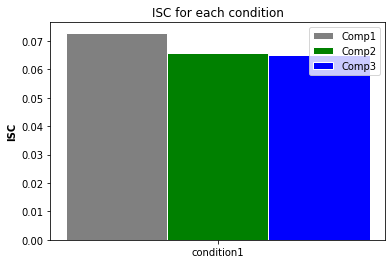

<ipython-input-16-20d32870dd30>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(isc_all.keys())


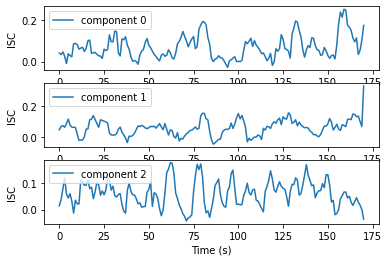

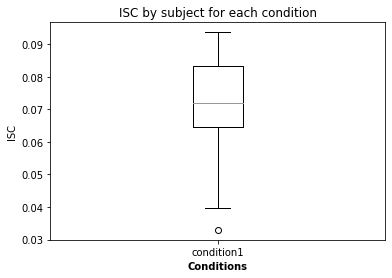

In [16]:
import matplotlib.pyplot as plt
import numpy as np


def plot_isc(isc_all):
    # plot ISC as a bar chart
    plt.figure()
    comp1 = [cond['ISC'][0] for cond in isc_all.values()]
    comp2 = [cond['ISC'][1] for cond in isc_all.values()]
    comp3 = [cond['ISC'][2] for cond in isc_all.values()]
    barWidth = 0.2
    r1 = np.arange(len(comp1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    plt.bar(r1, comp1, color='gray', width=barWidth, edgecolor='white', label='Comp1')
    plt.bar(r2, comp2, color='green', width=barWidth, edgecolor='white', label='Comp2')
    plt.bar(r3, comp3, color='blue', width=barWidth, edgecolor='white', label='Comp3')
    plt.xticks([r + barWidth for r in range(len(comp1))], isc_all.keys())
    plt.ylabel('ISC', fontweight='bold')
    plt.title('ISC for each condition')
    plt.legend()
    plt.show()

    # plot ISC_persecond
    for cond in isc_all.values():
        for comp_i in range(0, 3):
            plt.subplot(3, 1, comp_i+1)
            plt.plot(cond['ISC_persecond'][comp_i])
            

            plt.legend(['component {}'.format(comp_i)])
            plt.xlabel('Time (s)')
            plt.ylabel('ISC')
            #plt.title('ISC per second for each condition')


    # plot ISC_bysubject
    fig, ax = plt.subplots()
    ax.set_title('ISC by subject for each condition')
    a = [cond['ISC_bysubject'][0, :] for cond in isc_all.values()]
    ax.set_xticklabels(isc_all.keys())
    ax.set_ylabel('ISC')
    ax.set_xlabel('Conditions', fontweight='bold')
    ax.boxplot(a)

    
plot_isc(isc_results)


In [55]:
dic = dict()

dic['condition1'] = np.append(sub1_raw.get_data()[:91,516:85516].reshape(1,91,85000),sub2_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)

#for i in range(2,10):
#    dic['condition1'] = np.append(dic['condition1'],sub[i].get_data()[:,:86030].reshape(1,92,86030) ,axis=0)

dic['condition1'] = np.append(dic['condition1'],sub3_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub4_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub5_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub6_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub7_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub8_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub9_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub10_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)    

# Adding events into the raw structure

In [9]:
raw.add_events(events[:-1], stim_channel = 'stim_channel',replace = False)

In [10]:
raw['stim_channel'] # sanity check, it produces 2 arrays.. the last one is just the time slots.3.52e+02 = 352seconds

(array([[   0., 9999.,    0., ...,    0.,    0.,    0.]]),
 array([0.00000e+00, 2.00000e-03, 4.00000e-03, ..., 1.18924e+02,
        1.18926e+02, 1.18928e+02]))

In [41]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: E2, E3, E4, E5, E6, E7, E9, E10, E11, E12, E13, E15, E16, E18, ...
 chs: 91 EEG, 1 STIM
 custom_ref_applied: False
 dig: 114 items (3 Cardinal, 111 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 92
 projs: []
 sfreq: 500.0 Hz
>

# Plotting the Electrodes

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


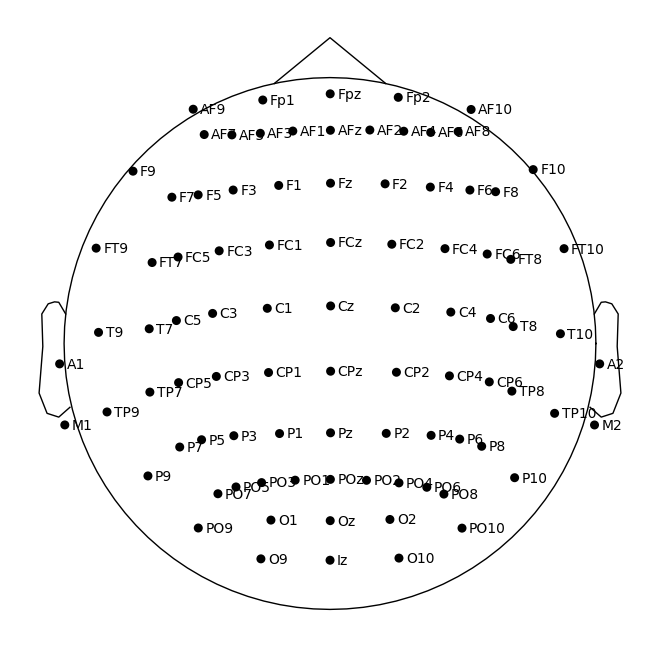

In [77]:
%matplotlib qt
montage_1020 = mne.channels.make_standard_montage("standard_1020")
#montage_hydro = mne.channels.make_standard_montage("GSN-HydroCel-129") #without the removal of the bad electrodes

#http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.116.7379&rep=rep1&type=pdf

# for an easier comparison, plotting in a separate windows. However only the 2nd plot is shown inside the notebook
raw.plot_sensors(show_names=True,title='HydroCel')

montage_1020.plot()

In [64]:

# kind = kinda standard which has 3D coordinates for 128 electrodes and 3 default things
montage_plot = mne.channels.make_standard_montage(kind= "GSN-HydroCel-129")  
# Note: By default, the 3d plots displayed here does not show the 3rd axis, thus require a
# a package called qt, can be called with %matplotlib qt
%matplotlib qt

fig = montage_plot.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)


Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


## Raw data in time domain

In [66]:
from plotly.graph_objs import Layout, YAxis, Scatter, Annotation, Annotations, Data, Figure, Marker, Font
from plotly import tools
from plotly import graph_objects
import chart_studio.plotly as py
import matplotlib.pyplot as plt

n_channels = 20
start, stop = raw.time_as_index([0, 5])
picks = mne.pick_channels(raw.ch_names, include=raw.ch_names[:n_channels], exclude=[])


data, times = raw[picks[:n_channels], start:stop]
ch_names = [raw.info['ch_names'][p] for p in picks[:n_channels]]
#ch_names


step = 1. / n_channels
kwargs = dict(domain=[1 - step, 1], showticklabels=False, zeroline=False, showgrid=False)

# create objects for layout and traces
layout = Layout(yaxis=YAxis(kwargs), showlegend=False)
traces = [Scatter(x=times, y=data.T[:, 0])]

# loop over the channels
for ii in range(1, n_channels):
        kwargs.update(domain=[1 - (ii + 1) * step, 1 - ii * step])
        layout.update({'yaxis%d' % (ii + 1): YAxis(kwargs), 'showlegend': False})
        traces.append(Scatter(x=times, y=data.T[:, ii], yaxis='y%d' % (ii + 1)))

# add channel names using Annotations
annotations = Annotations([Annotation(x=-0.06, y=0, xref='paper', yref='y%d' % (ii + 1),
                                      text=ch_name, font=Font(size=9), showarrow=False)
                          for ii, ch_name in enumerate(ch_names)])
layout.update(annotations=annotations)

# set the size of the figure and plot it
layout.update(autosize=False, width=1000, height=600)
fig = Figure(data=Data(traces), layout=layout)
fig.show()
fig.write_html("raw_time_domain.html")


In [70]:
from IPython.display import IFrame
IFrame(src='raw_time_domain.html', width=1000, height=600)

# Epoch (ing) the raw data

In [21]:
epochs = mne.Epochs(raw, events[:-1], [81,101,9999], tmin=0, tmax=20,preload=True,baseline=(0,None))
#epochs = epochs.average() # This is an average per event
np.shape(epochs.load_data())

Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 10001 original time points ...
1 bad epochs dropped


(2, 92, 10001)

# Topo Plot

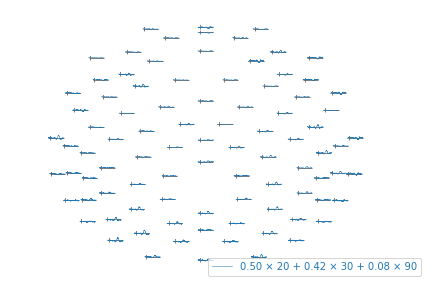

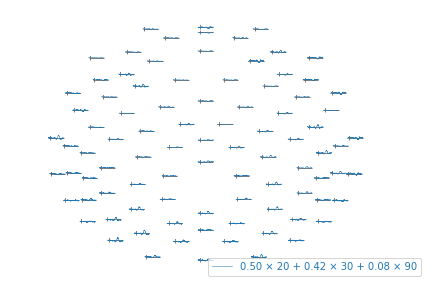

In [61]:
layout = mne.find_layout(epochs.info)
epochs.plot_topo(layout=layout)


# Plotting events

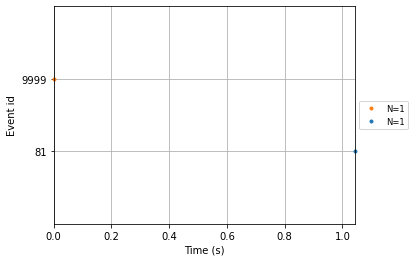

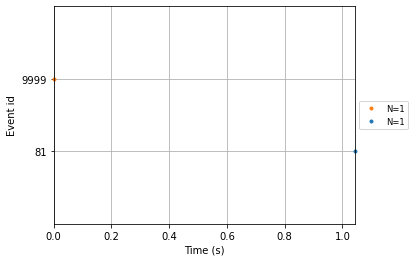

In [45]:
mne.viz.plot_events(events[:-1], sfreq=raw.info['sfreq'])
#The last event 20 falls on 174120 and the last sample is 176386. That's just 4 seconds before the end of the EEG

# Raw PSD 

Effective window size : 4.096 (s)


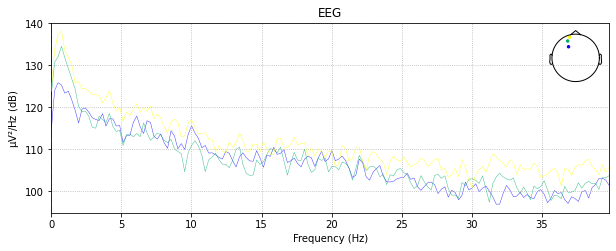

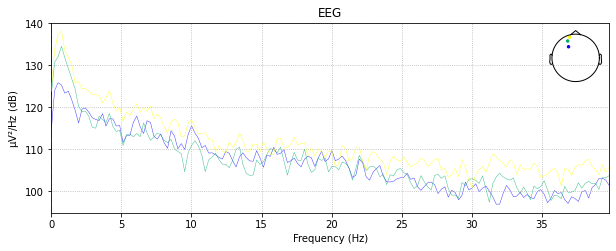

In [46]:
mne.viz.plot_raw_psd(raw,tmax=40,fmax=40,picks=['E22','E20','E23'])

# Covariance

In [124]:
# Plotting covariance
sub1_covariance = mne.compute_raw_covariance(sub1_raw, method=['empirical'])

Using up to 860 segments
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 91 dim * 9e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
Reducing data rank from 91 -> 91
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 86000
[done]


    Using multitaper spectrum estimation with 7 DPSS windows


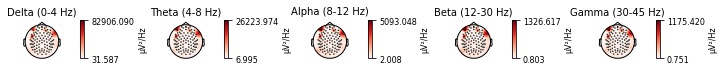

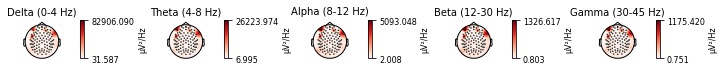

In [49]:
mne.viz.plot_epochs_psd_topomap(epochs)

# PSD plot for the electrodes located in Occipital lobe

			EVENT IN THE GRAPH BELOW IS = 9999
			NOTE, EYES OPEN = 20 & EYES CLOSE = 30
Effective window size : 1.044 (s)


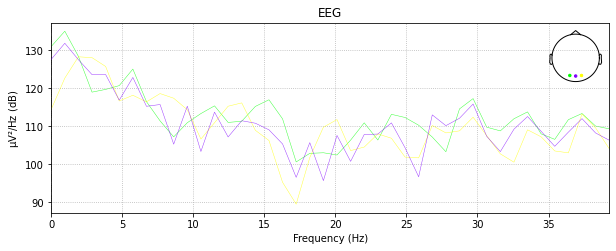

			EVENT IN THE GRAPH BELOW IS = 81
			NOTE, EYES OPEN = 20 & EYES CLOSE = 30
Effective window size : 4.096 (s)


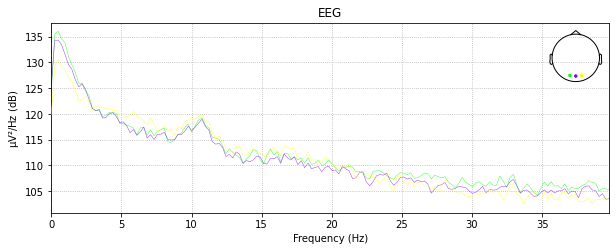

In [48]:
for i in range(0,2): #0 is 90 = beginning of EEG, so skipped
    #plt.title('event ={}. Note: open = 20'.format(events[i][2])) this works nicely if plotted through qt
    print("\t\t\tEVENT IN THE GRAPH BELOW IS = {}".format(events[i][2]))
    print("\t\t\tNOTE, EYES OPEN = 20 & EYES CLOSE = 30")
    mne.viz.plot_raw_psd(raw,tmin= events[i][0]/500,tmax=events[i+1][0]/500,fmax=40,picks=['E70','E75','E83'])


In [ ]:
# TO-do
# Check the videos vs activations' correlation
# 

In [49]:
cd

/homes/v20subra


In [90]:
from mne.datasets import fetch_fsaverage

import os.path as op
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)


subject = 'fsaverage' # Subject ID for the MRI-head transformation
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
source_space = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif') 
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage


In [91]:
fwd_model = mne.make_forward_solution(sub1_raw.info, trans=trans, src=source_space, bem=bem, eeg=True, mindist=5.0)

Source space          : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /homes/v20subra/.local/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  91 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BE

In [155]:
from mne.minimum_norm import make_inverse_operator, apply_inverse, apply_inverse_epochs

inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov)



Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 4.8e-05 (2.2e-16 eps * 91 dim * 2.4e+09  max singular value)
    Estimated rank (eeg): 5
    EEG: rank 5 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-155-2d3253c51613>:3: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov)
<ipython-input-155-2d3253c51613>:3: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(sub1_raw.info, fwd_model, cov)


    largest singular value = 1.68731
    scaling factor to adjust the trace = 1.70701e+09 (nchan = 91 nzero = 86)


In [153]:
epoc = mne.EpochsArray(np.reshape(isc_results['condition1']['A'][:5],[1,91,5]),mne.create_info(sub1_raw.info['ch_names'],sfreq=500,ch_types = 'eeg'))

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [154]:
cov =mne.compute_covariance(epoc)

Computing rank from data with rank=None
    Using tolerance 1.1e-09 (2.2e-16 eps * 5 dim * 9.7e+05  max singular value)
    Estimated rank (eeg): 5
    EEG: rank 5 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 91 -> 5
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 5
[done]


<ipython-input-154-44dd090cbe67>:1: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov =mne.compute_covariance(epoc)
<ipython-input-154-44dd090cbe67>:1: RuntimeWarning: Too few samples (required : 460 got : 5), covariance estimate may be unreliable
  cov =mne.compute_covariance(epoc)
<ipython-input-154-44dd090cbe67>:1: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  cov =mne.compute_covariance(epoc)


In [156]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2

# epochs['30'].average() = Averaged evoked response for the event 30
stc = apply_inverse_epochs(epoc, inverse_operator, lambda2,
                             method=method, pick_ori=None, verbose=True)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 5 (86 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3.7e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]


In [157]:
vertno_max, time_max = stc[0].get_peak()
%matplotlib qt
%gui qt # Solves the black-screen on mayavi front. This 5 letters, 2 words took me hours and hours to figure out :D

fig, ax = plt.subplots()
ax.plot(1e3 * stc[0].times, stc[0].data[::100, :].T)
ax.set(xlabel='time (ms)', ylabel='%s value' % method)
brain = stc[0].plot(subjects_dir=subjects_dir, initial_time=time_max, time_unit='s',hemi='both')
#surfer_kwargs = dict(
 #   hemi='both', subjects_dir=subjects_dir,
  #  clim=dict(kind='value', lims=[8, 12, 15]), views='lateral',
   # initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
#brain = stc.plot(**surfer_kwargs)
brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',scale_factor=0.6, alpha=0.5)
brain.add_foci(vertno_max, coords_as_verts=True, hemi='lh', color='red',scale_factor=0.6, alpha=0.5)

brain.add_text(0.1, 0.9, 'eLORETA', 'title' ,font_size=14)



ERROR:root:Invalid GUI request 'qt # Solves the black-screen on mayavi front. This 5 letters, 2 words took me hours and hours to figure out :D', valid ones are:dict_keys(['inline', 'nbagg', 'notebook', 'ipympl', 'widget', None, 'qt4', 'qt', 'qt5', 'wx', 'tk', 'gtk', 'gtk3', 'osx', 'asyncio'])


Using control points [8.27391828e-07 8.73291828e-07 1.13735994e-06]
